In [1]:
import re
import numpy as np
import pandas as pd
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas_profiling as pp
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook
# nltk
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importando Dados do CSV

In [2]:
#colab_events_url = 'https://drive.google.com/uc?id=1d1ZZ1ramHTjnOOnSc_sdcKEQm2si1Lib&export=download' #2020-2022 Niteroi
colab_events_url = 'https://drive.google.com/uc?id=1EN-RuRUjnMCiMzzjcEqcjMLMCBGRYU6b&export=download' #All Data
colab_events_test = pd.read_csv(colab_events_url, low_memory=False)
print(colab_events_test.shape)
colab_events_test.head(2)

(2000, 4)


,event_id,user_id,description,score
0,341145.0,380494.0,"Esse trecho da rua São João, entre as ruas Vis...",-11.717
1,220629.0,316442.0,Moradores dos condominios ao redor do Posto Ip...,-11.478


# Importando dados de Treinamento

In [3]:
colab_train_url = "https://drive.google.com/uc?id=1phfPuZjpwAMCqOoR9YgkbK2F0x9p-KUa&export=download" #2020-2022 Niteroi
#colab_train_url = 'https://drive.google.com/uc?id=1EN-RuRUjnMCiMzzjcEqcjMLMCBGRYU6b&export=download' #All Data
colab_events_train = pd.read_csv(colab_train_url, low_memory=False)
print(colab_events_train.shape)
colab_events_train.head(2)

(2000, 4)


,event_id,user_id,description,score
0,341145.0,380494.0,"Esse trecho da rua São João, entre as ruas Vis...",-11.717
1,220629.0,316442.0,Moradores dos condominios ao redor do Posto Ip...,-11.478


# Testando se há valores nulos

In [4]:
colab_events_train.isnull().any()
colab_events_test.isnull().any()

event_id       False
user_id        False
description    False
score          False
dtype: bool

event_id       False
user_id        False
description    False
score          False
dtype: bool

# Postagens com menor score

In [5]:
df = colab_events_train[colab_events_train['score'] <= 0]
df.shape
df.head(10)

(1000, 4)

,event_id,user_id,description,score
0,341145.0,380494.0,"Esse trecho da rua São João, entre as ruas Vis...",-11.717
1,220629.0,316442.0,Moradores dos condominios ao redor do Posto Ip...,-11.478
2,169518.0,249968.0,nos aqui da região vamos continuar insistindo ...,-11.158
3,50837.0,125536.0,Vasos colocados irregularmente nas vagas desti...,-10.739
4,238846.0,276570.0,"Rua Vereador José Fernandes, no bairro de Sant...",-10.674
5,95796.0,128160.0,"Cúmulo, em plena Praia de Piratininga um conju...",-10.448
6,289608.0,200307.0,"Calçada irregular, fora de nível das calçadas,...",-10.422
7,246633.0,128160.0,como passat na via xavier diante de tanta irre...,-9.889
8,246634.0,128160.0,como passat na via xavier diante de tanta irre...,-9.889
9,360146.0,661707.0,é uma absurdo o que acontece nesse sinal dessa...,-9.764


# Postagens com maior score

In [6]:
df = colab_events_train[colab_events_train['score'] >= 1]
df.shape
df.head(10)

(1000, 4)

,event_id,user_id,description,score
1000,126911.0,203387.0,"Cachorro em uma construção, o animal é maltrat...",13.252
1001,269175.0,346338.0,em 22 de setembro de 2020 devido à uma forte c...,13.256
1002,357068.0,471711.0,Boa tarde\nMe parece que é permitido cometer i...,13.264
1003,277078.0,362895.0,"dia 12 de janeiro de 2019, um galho enorme da ...",13.271
1004,130367.0,214502.0,olá senhores venho solicitar que venha poda es...,13.277
1005,214982.0,307156.0,"Nesta casa, localizada na Rua Jovita, n° 50, n...",13.279
1006,59333.0,59717.0,"(Foto rua Roma). Prefeitura, mais uma vez, de ...",13.281
1007,124005.0,206108.0,um absurdo a passagem de ônibus em santo Andre...,13.288
1008,175684.0,159617.0,"O muriqui Pequeno está no escuro, cada dia que...",13.294
1009,239017.0,301900.0,Sou morador que fica atrás desse bar... hoje é...,13.297


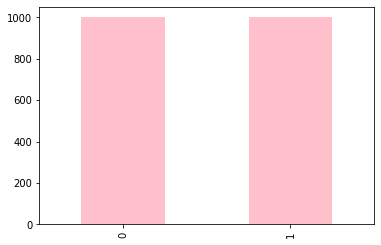

In [7]:
# no dataset original, 0 seria neutro, -1 negativo e 1 positivo. esse algoritmo não conta AINDA com a posiçao, neutra entao precisamos botar tudo 0 ou 1 com a lambda abaixo
colab_events_train['score_norm'] = colab_events_train['score'].apply(lambda x: 1 if x>=1 else 0)
colab_events_train['score_norm'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

# Tamanho das postagens em ambos datasets

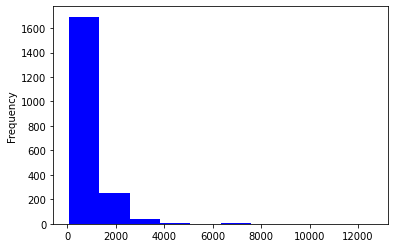

In [8]:
length_test = colab_events_test['description'].str.len().plot.hist(color = 'blue', figsize = (6, 4))


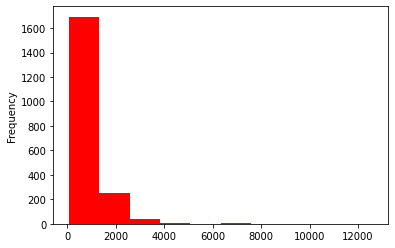

In [9]:
length_train = colab_events_train['description'].str.len().plot.hist(color = 'red', figsize = (6, 4))

# Adicionando coluna para tamanho da postagem

In [10]:
colab_events_train['len'] = colab_events_train['description'].str.len()
colab_events_test['len'] = colab_events_train['description'].str.len()

colab_events_train.head(10)

,event_id,user_id,description,score,score_norm,len
0,341145.0,380494.0,"Esse trecho da rua São João, entre as ruas Vis...",-11.717,0,843
1,220629.0,316442.0,Moradores dos condominios ao redor do Posto Ip...,-11.478,0,1067
2,169518.0,249968.0,nos aqui da região vamos continuar insistindo ...,-11.158,0,932
3,50837.0,125536.0,Vasos colocados irregularmente nas vagas desti...,-10.739,0,2475
4,238846.0,276570.0,"Rua Vereador José Fernandes, no bairro de Sant...",-10.674,0,772
5,95796.0,128160.0,"Cúmulo, em plena Praia de Piratininga um conju...",-10.448,0,738
6,289608.0,200307.0,"Calçada irregular, fora de nível das calçadas,...",-10.422,0,571
7,246633.0,128160.0,como passat na via xavier diante de tanta irre...,-9.889,0,560
8,246634.0,128160.0,como passat na via xavier diante de tanta irre...,-9.889,0,560
9,360146.0,661707.0,é uma absurdo o que acontece nesse sinal dessa...,-9.764,0,558


# Agrupando por score

In [11]:
colab_events_train.groupby('score').describe()

event_id                                                              \
            count      mean       std       min       25%       50%       75%   
score                                                                           
-11.717       1.0  341145.0       NaN  341145.0  341145.0  341145.0  341145.0   
-11.478       1.0  220629.0       NaN  220629.0  220629.0  220629.0  220629.0   
-11.158       1.0  169518.0       NaN  169518.0  169518.0  169518.0  169518.0   
-10.739       1.0   50837.0       NaN   50837.0   50837.0   50837.0   50837.0   
-10.674       1.0  238846.0       NaN  238846.0  238846.0  238846.0  238846.0   
...           ...       ...       ...       ...       ...       ...       ...   
 51.410       1.0  157176.0       NaN  157176.0  157176.0  157176.0  157176.0   
 54.547       1.0  185542.0       NaN  185542.0  185542.0  185542.0  185542.0   
 55.604       2.0  322834.0  1.414214  322833.0  322833.5  322834.0  322834.5   
 57.099       1.0  214052.0       NaN  214052.0  214052.0  214052.0  214052.0   
 129.283      1.0  222630.0       NaN  222630.0  222630.0  222630.0  222630.0   

                   user_id            ... score_norm        len          \
               max   count      mean  ...        75%  max count    mean   
score                                 ...                                 
-11.717   341145.0     1.0  380494.0  ...        0.0  0.0   1.0   843.0   
-11.478   220629.0     1.0  316442.0  ...        0.0  0.0   1.0  1067.0   
-11.158   169518.0     1.0  249968.0  ...        0.0  0.0   1.0   932.0   
-10.739    50837.0     1.0  125536.0  ...        0.0  0.0   1.0  2475.0   
-10.674   238846.0     1.0  276570.0  ...        0.0  0.0   1.0   772.0   
...            ...     ...       ...  ...        ...  ...   ...     ...   
 51.410   157176.0     1.0  237119.0  ...        1.0  1.0   1.0  7198.0   
 54.547   185542.0     1.0  199306.0  ...        1.0  1.0   1.0  7102.0   
 55.604   322835.0     2.0  416662.0  ...        1.0  1.0   2.0  6605.0   
 57.099   214052.0     1.0  308915.0  ...        1.0  1.0   1.0  3123.0   
 129.283  222630.0     1.0  310177.0  ...        1.0  1.0   1.0  8549.0   

                                                            
               std     min     25%     50%     75%     max  
score                                                       
-11.717        NaN   843.0   843.0   843.0   843.0   843.0  
-11.478        NaN  1067.0  1067.0  1067.0  1067.0  1067.0  
-11.158        NaN   932.0   932.0   932.0   932.0   932.0  
-10.739        NaN  2475.0  2475.0  2475.0  2475.0  2475.0  
-10.674        NaN   772.0   772.0   772.0   772.0   772.0  
...            ...     ...     ...     ...     ...     ...  
 51.410        NaN  7198.0  7198.0  7198.0  7198.0  7198.0  
 54.547        NaN  7102.0  7102.0  7102.0  7102.0  7102.0  
 55.604   7.071068  6600.0  6602.5  6605.0  6607.5  6610.0  
 57.099        NaN  3123.0  3123.0  3123.0  3123.0  3123.0  
 129.283       NaN  8549.0  8549.0  8549.0  8549.0  8549.0  

[1713 rows x 32 columns]

# Grafico de variaçao por tamanho da postagem

Text(0.5, 1.0, 'variation of length')

Text(0.5, 0, 'Length')

Text(0, 0.5, 'Score')

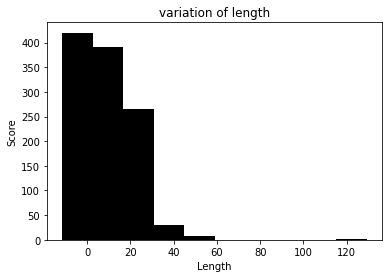

In [12]:
colab_events_train.groupby('len').mean()['score'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.ylabel("Score")
plt.show()

# Preparando para motor de linguística

In [13]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords_set = set(stopwords)
def SanitizePhrase(phrase):
  result = "";
  for word in phrase.split(" "):
    review = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', word)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    # stemming
    review = [ps.stem(word) for word in review if not word in stopwords_set]
    if(review):
      if(len(review[0]) > 2):
        result += review[0] + " "
  return result.strip()
#
print(SanitizePhrase("O rato roeu a roupa do rei de roma joão josé"))

rato roeu roupa rei roma joão josé


# Palavras mais utilizadas em geral

Text(0.5, 1.0, 'Palavras mais utilizadas - Top 50')

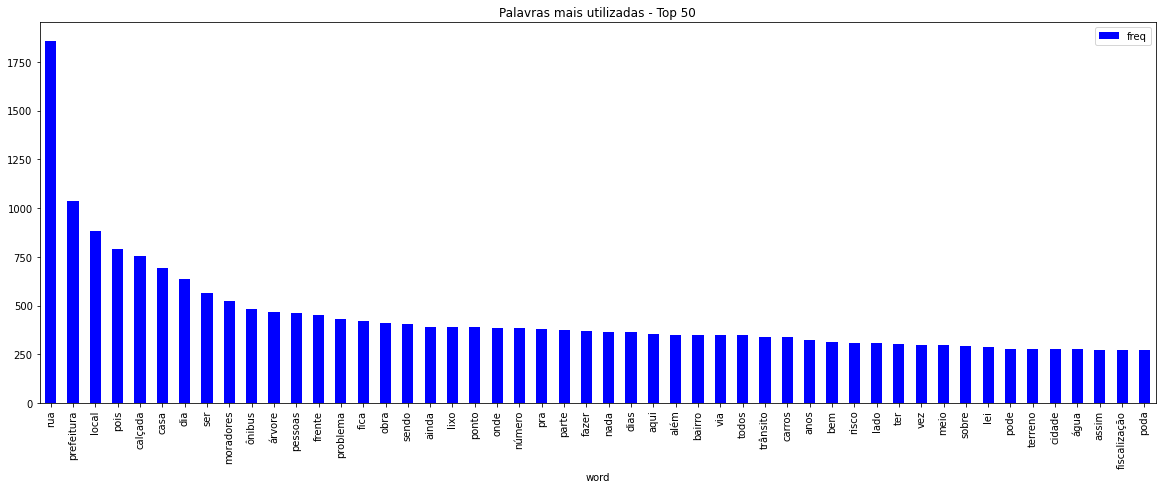

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = nltk.corpus.stopwords.words('portuguese'))
words = cv.fit_transform(colab_events_train.description)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(20, 7), color = 'blue')
plt.title("Palavras mais utilizadas - Top 50")

# Word Cloud

<Figure size 1440x576 with 0 Axes>

Text(0.5, 1.0, 'WordCloud')

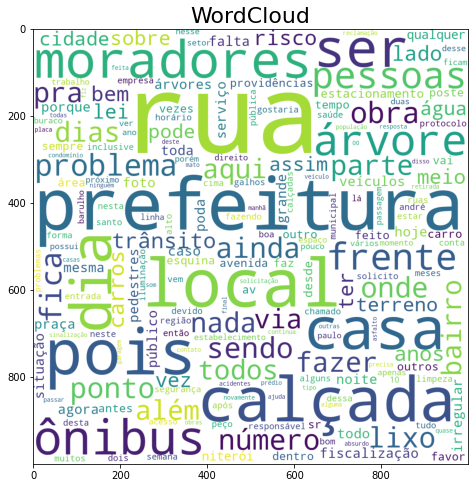

In [15]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.title("WordCloud", fontsize = 22)

<Figure size 720x504 with 0 Axes>

(-0.5, 799.5, 499.5, -0.5)

Text(0.5, 1.0, 'Palavras mais frequentes em postagens positivas')

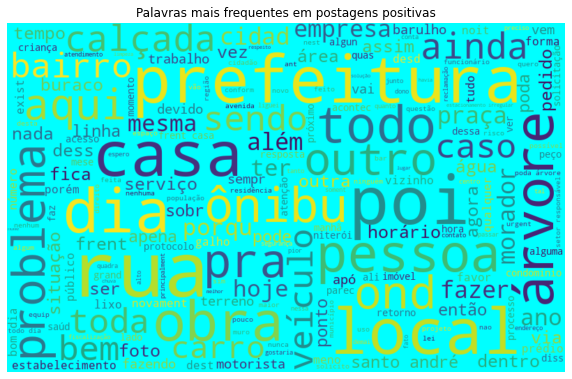

In [16]:
normal_words =' '.join([text for text in colab_events_train['description'][colab_events_train['score'] >= 1]])
normal_words = SanitizePhrase(normal_words)
wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palavras mais frequentes em postagens positivas')
plt.show()


<Figure size 720x504 with 0 Axes>

(-0.5, 799.5, 499.5, -0.5)

Text(0.5, 1.0, 'Palavras mais frequentes em postagens negativas')

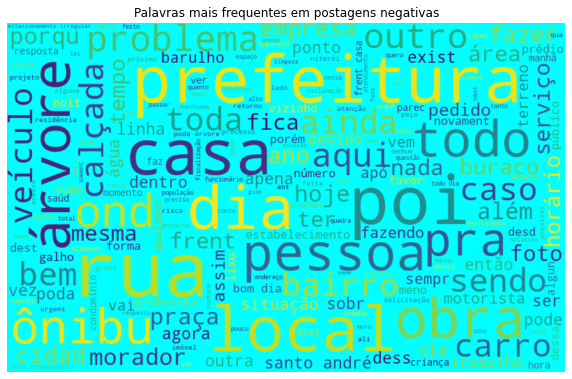

In [17]:
negative_words =' '.join([text for text in colab_events_train['description'][colab_events_train['score'] <= 0 ]])
negative_words = SanitizePhrase(normal_words)
wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palavras mais frequentes em postagens negativas')
plt.show()

# Loop de criaçao do modelo de vetores léxicos

In [18]:
# tokenizing the words present in the training set
tokenized_tweet = colab_events_train['description'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 50, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(colab_events_train['description']), epochs=20)

(3858893, 5331440)

In [19]:
import string
def MostSimilarTagCloud(most_similar, title, color):
  most_str = ""
  for i in most_similar:
    most_str += i[0] + " "
  wordcloud = WordCloud(background_color = color, width=800, height=500, random_state = 0, max_font_size = 110).generate(most_str.translate(most_str.maketrans('', '', string.punctuation)))
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title)
  plt.show()

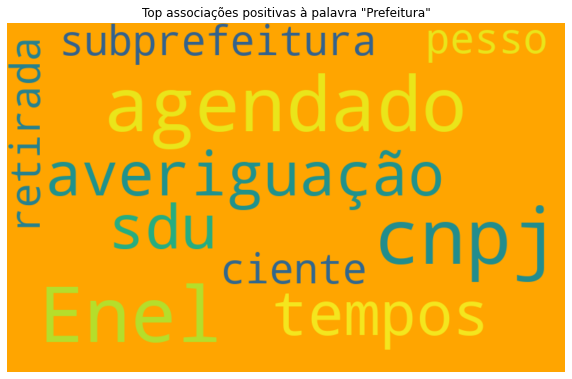

In [20]:
MostSimilarTagCloud(model_w2v.wv.most_similar(positive = "prefeitura"), 'Top associações positivas à palavra "Prefeitura"', 'orange')

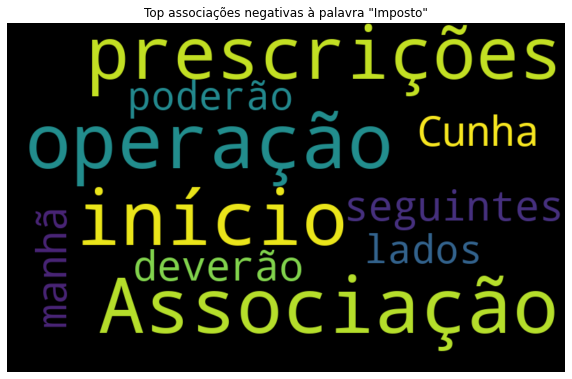

In [21]:
MostSimilarTagCloud(model_w2v.wv.most_similar(negative = ["iptu"]), 'Top associações negativas à palavra "Imposto"', 'black')

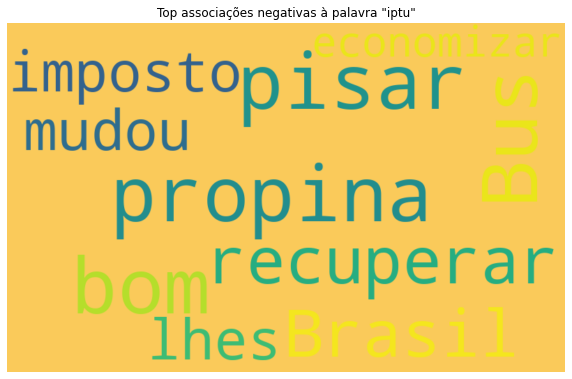

In [22]:
MostSimilarTagCloud(model_w2v.wv.most_similar(positive = ["iptu"]), 'Top associações negativas à palavra "iptu"', '#faca5a')

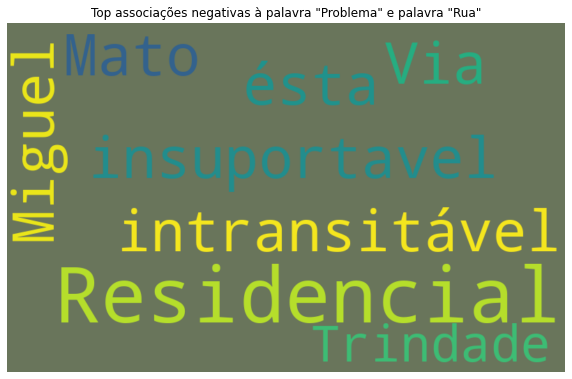

In [23]:
MostSimilarTagCloud(model_w2v.wv.most_similar(positive=['rua'], negative=['problema']), 'Top associações negativas à palavra "Problema" e palavra "Rua"', '#69755b')

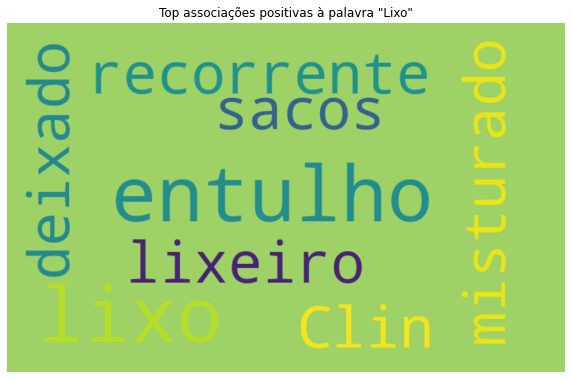

In [24]:
MostSimilarTagCloud(model_w2v.wv.most_similar(positive=['lixo']), 'Top associações positivas à palavra "Lixo"', '#9ed166')

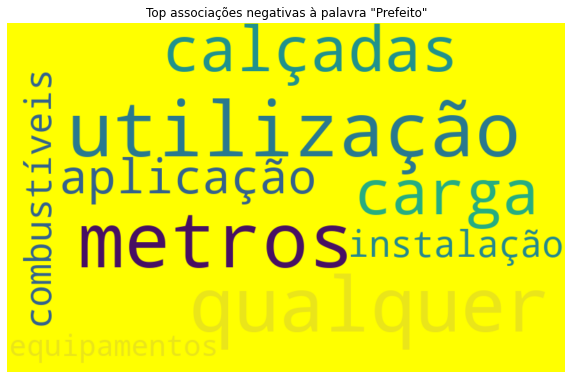

In [25]:
MostSimilarTagCloud(model_w2v.wv.most_similar(negative=['prefeito']), 'Top associações negativas à palavra "Prefeito"', 'yellow')

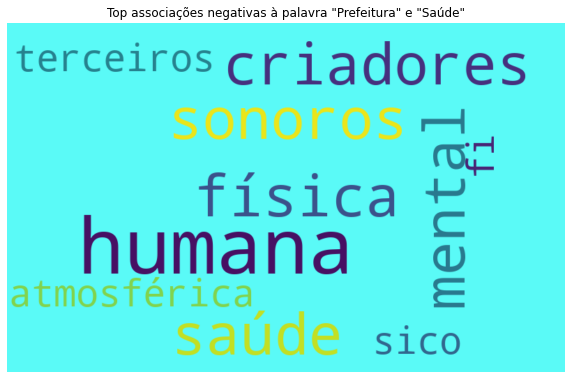

In [26]:
MostSimilarTagCloud(model_w2v.wv.most_similar(positive=['saúde'], negative=['prefeitura']), 'Top associações negativas à palavra "Prefeitura" e "Saúde"', '#5afaf7')

In [27]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


[LabeledSentence(words=['Esse', 'trecho', 'da', 'rua', 'São', 'João,', 'entre', 'as', 'ruas', 'Visconde', 'de', 'Itaboraí', 'e', 'do', 'Uruguai,', 'não', 'bastasse', 'a', 'indigência', 'dos', 'que', 'ali', 'habitam', 'ou', 'têm', 'seus', 'comércios', 'irregulares,', 'por', 'falta', 'de', 'melhor', 'opção,', 'temos', 'várias', 'figueiras', 'horrorosas,', 'que', 'estragam', 'as', 'calçadas', 'e', 'até', 'a', 'via', 'pública.', 'Atualmente,', 'estão', 'perdendo', 'as', 'folhas,', 'o', 'que', 'colabora', 'para', 'sujar', 'ainda', 'mais', 'essa', 'via.', 'São', 'ótimas', 'para', 'entupir', 'os', 'raros', 'bueiros', 'que,', 'quando', 'chove,', 'drenam', 'as', 'águas', 'pluviais.', 'A', 'sugestão', 'é', 'que', 'erradiquem', 'essas', 'espécies', 'exóticas', 'indesejadas,', 'e', 'no', 'lugar', 'delas', 'implantem', 'especies', 'nativas,', 'como', 'o', 'Pau', 'Ferro', '(C.', 'férrea),', 'como', 'ilustrado', 'peia', 'foto', 'do', 'trecho', 'que', 'atravessa', 'essa', 'praça.', 'Mas', 'com', 'indi

In [38]:
# removing unwanted patterns from the data

train_corpus = []

for i in range(0, len(colab_events_train)):
  review = re.sub('[^a-zA-Z]', ' ', colab_events_train['description'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(nltk.corpus.stopwords.words('portuguese'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [39]:
test_corpus = []

for i in range(0, len(colab_events_test)):
  review = re.sub('[^a-zA-Z]', ' ', colab_events_test['description'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(nltk.corpus.stopwords.words('portuguese'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [40]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = len(colab_events_train))
x = cv.fit_transform(train_corpus).toarray()
y = colab_events_train.iloc[:, 1]


print(x.shape)
print(y.shape)

(2000, 2500)
(2000,)


In [49]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = len(colab_events_test))
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

(2000, 10000)


In [50]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1500, 2500)
(500, 2500)
(1500,)
(500,)


In [53]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.fit_transform(x_test)

# RandomForestClassifier
Last Run:
*   2022-05-19
    * Training Accuracy : 0.996
    * Validation Accuracy : 0.172
*   2022-05-15
    * Training Accuracy : 1.0
    * Validation Accuracy : 0.14



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred, average = "weighted"))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

RandomForestClassifier()

Training Accuracy : 0.996
Validation Accuracy : 0.166
F1 score : 0.13486916416916417
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# LogisticRegression
Last Run:
*   2022-05-19
  * Training Accuracy : 0.996
  * Validation Accuracy : 0.164
*   2022-05-15
  * Training Accuracy : 1.0
  *  Validation Accuracy : 0.16



In [56]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred, average = "weighted"))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Training Accuracy : 0.996
Validation Accuracy : 0.164
f1 score : 0.15277142857142853
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# DecisionTreeClassifier
Last Run:
*   2022-05-19
  * Training Accuracy : 0.996
  * Validation Accuracy : 0.13
*   2022-05-15
  *   Training Accuracy : 1.0
  *   Validation Accuracy : 0.1



In [46]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred, average = "weighted"))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

DecisionTreeClassifier()

Training Accuracy : 0.996
Validation Accuracy : 0.13
f1 score : 0.12407052334638541
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# SVC
Last Run:
*   2022-05-19
  *   Training Accuracy : 0.3953333333333333
  *   Validation Accuracy : 0.098
*   2022-05-15
  *   Training Accuracy : 0.5906040268456376
  *   Validation Accuracy : 0.1



In [47]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred, average = "weighted"))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

SVC()

Training Accuracy : 0.3953333333333333
Validation Accuracy : 0.098
f1 score : 0.06302257777667997
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# XGBClassifier
Last Run:
*   2022-05-15
*   Training Accuracy : 0.31543624161073824
*   Validation Accuracy : 0.1



In [48]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred, average = "weighted"))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

XGBClassifier(objective='multi:softprob')

Training Accuracy : 0.27066666666666667
Validation Accuracy : 0.116
f1 score : 0.092150390459214
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
